In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import matplotlib.pyplot as plt

import os

import numpy as np

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

from sklearn.model_selection import train_test_split

from keras.layers import Input, Reshape, add
from keras.layers import ZeroPadding2D, Cropping2D, Conv2D, Conv2DTranspose, Activation
from keras.layers import LeakyReLU, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import Adam

from keras.utils.vis_utils import plot_model
from IPython.display import Image

import cv2

Using TensorFlow backend.


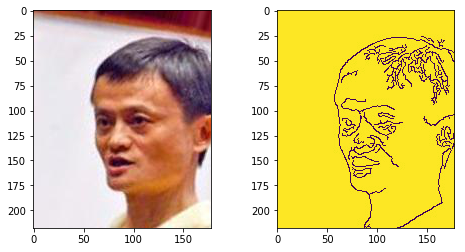

In [2]:
img_1 = imread( "./img_align_celeba/100010.jpg")
img_2 = imread("./edges/100010.jpg")
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_1, 'gray')
plt.subplot(1,2,2)
plt.imshow(img_2)

In [3]:
img_dir = "./img_align_celeba/"
edge_dir = "./edges/"

img_width = 178
img_height = 218
img_channels = 3
padding = 256
padding_width = padding - img_width
padding_height = padding - img_height

epochs=8
batch_size=32

In [4]:
files = os.listdir(img_dir)
train_, test_ = train_test_split(files, test_size=0.1)
train_t, train_v = train_test_split(train_, test_size=0.25)

train_img_files = [img_dir+i for i in train_t]
train_edge_files = [edge_dir+i for i in train_t]
val_img_files = [img_dir+i for i in train_v]
val_edge_files = [edge_dir+i for i in train_v]
test_img_files = [img_dir+i for i in test_]
test_edge_files = [edge_dir+i for i in test_]

len(train_img_files), len(train_edge_files), len(val_img_files), len(val_edge_files), len(test_img_files), len(test_edge_files)

(136754, 136754, 45585, 45585, 20260, 20260)

In [5]:
def image_generator(files, edges, batch_size):
    while True:
        for i in range(0, len(files)//batch_size):
            orig_images = np.empty(shape=(batch_size, img_height, img_width, img_channels), dtype=np.float)
            edge_images = np.empty(shape=(batch_size, img_height, img_width, ), dtype=np.float)
            for k, j in enumerate(range(i*batch_size, (i+1)*batch_size)):
                orig_images[k] = imread(files[j]) / 255.
                edge_images[k] = imread(edges[j]) / 255.
            yield edge_images, orig_images

In [6]:
def conv_block(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding="same")(inputs)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    return x

def transpose_block(inputs, skip_layer, filters, kernel_size, strides):
    x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, padding="same")(inputs)
    if skip_layer is not None:
        x = add([x, skip_layer])
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    return x

skip_layers = []
    
inputs = Input(shape=(img_height, img_width, ))
x = Reshape(target_shape=(img_height, img_width, 1))(inputs)
x = ZeroPadding2D(padding=((0, padding_height), (0, padding_width)))(x)

x = conv_block(x, 32, 5, 2)
for i in range(4):
    x = conv_block(x, 128, 5, 2)
    skip_layers.append(x)
x = conv_block(x, 128, 5, 2)

for i in range(4):
    x = transpose_block(x, skip_layers.pop(), 128, 5, 2)
x = transpose_block(x, None, 32, 5, 2)
x = transpose_block(x, None, 3, 5, 2)

x = Cropping2D(cropping=((0, padding_height), (0, padding_width)))(x)
outputs = Activation('sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 218, 178)     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 218, 178, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 256, 256, 1)  0           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 832         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
leaky_re_l

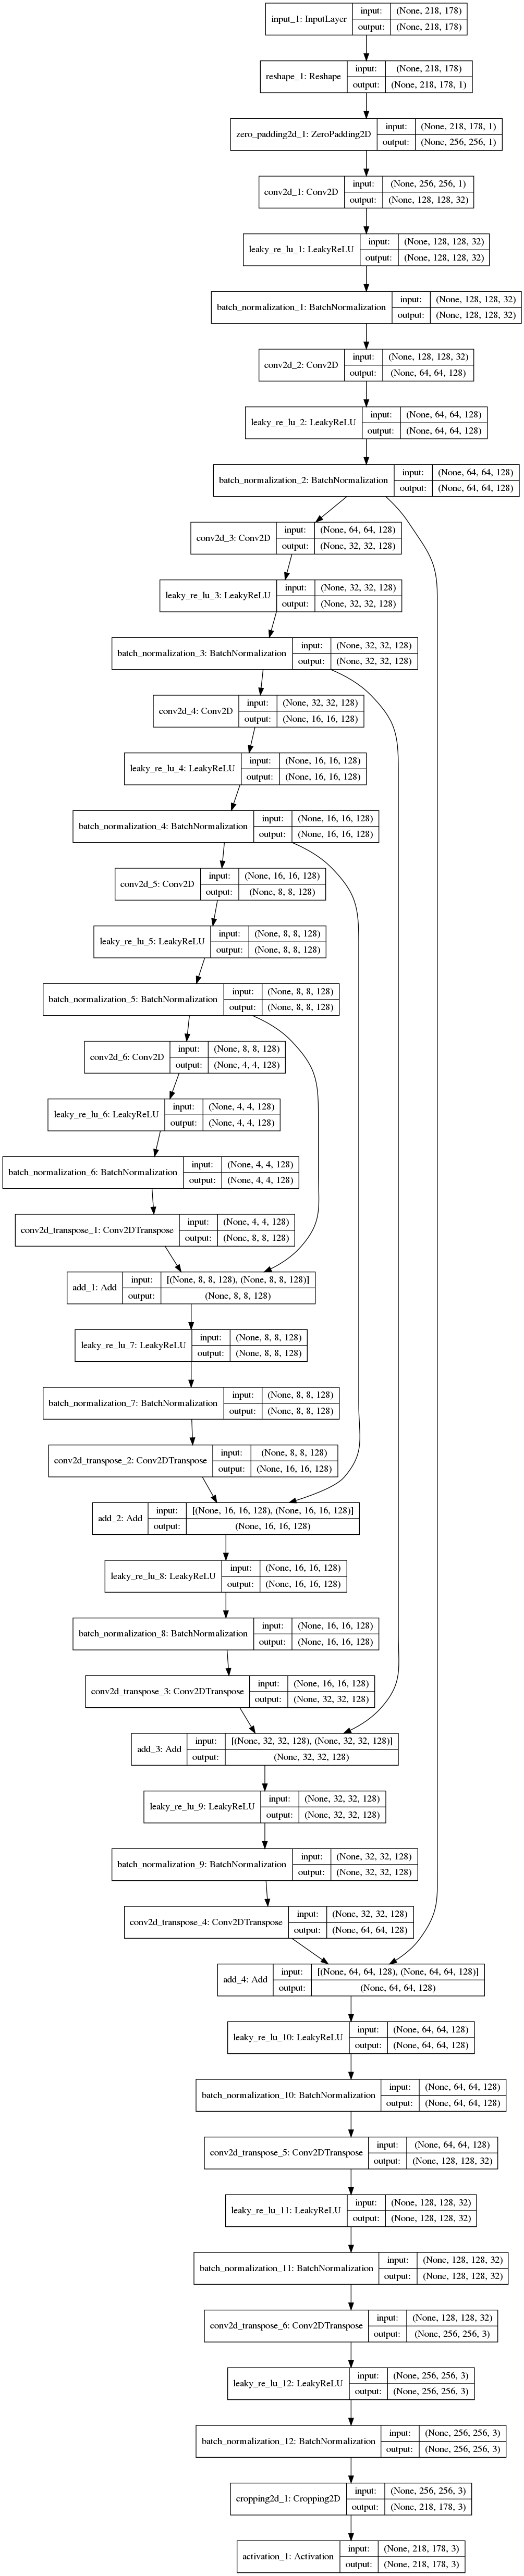

In [7]:
plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

In [8]:
from keras import metrics

model.compile(loss='mae', optimizer=Adam(0.001), metrics=[metrics.mae])

In [9]:
history = model.fit_generator(image_generator(train_img_files, train_edge_files, batch_size), 
                              steps_per_epoch=len(train_img_files)//batch_size,
                              validation_data=image_generator(val_img_files, val_edge_files, batch_size),
                              validation_steps=len(val_img_files)//batch_size,
                              epochs=epochs,
                              verbose=1)

Epoch 1/8
4273/4273 [==============================] - 3797s 889ms/step - loss: 0.1921 - mean_absolute_error: 0.1921 - val_loss: 0.2070 - val_mean_absolute_error: 0.2070
Epoch 2/8
4273/4273 [==============================] - 5075s 1s/step - loss: 0.1726 - mean_absolute_error: 0.1726 - val_loss: 0.2093 - val_mean_absolute_error: 0.2093
Epoch 3/8
2918/4273 [===================>..........] - ETA: 20:28 - loss: 0.1657 - mean_absolute_error: 0.1657

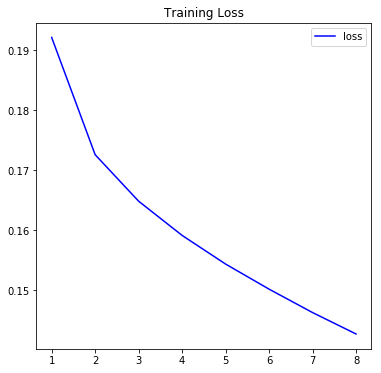

In [10]:
plt.rcParams['figure.figsize'] = (6,6)
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)
plt.title('Training Loss')
plt.plot(epochs, train_loss, 'blue', label='loss')
plt.legend()
plt.show()

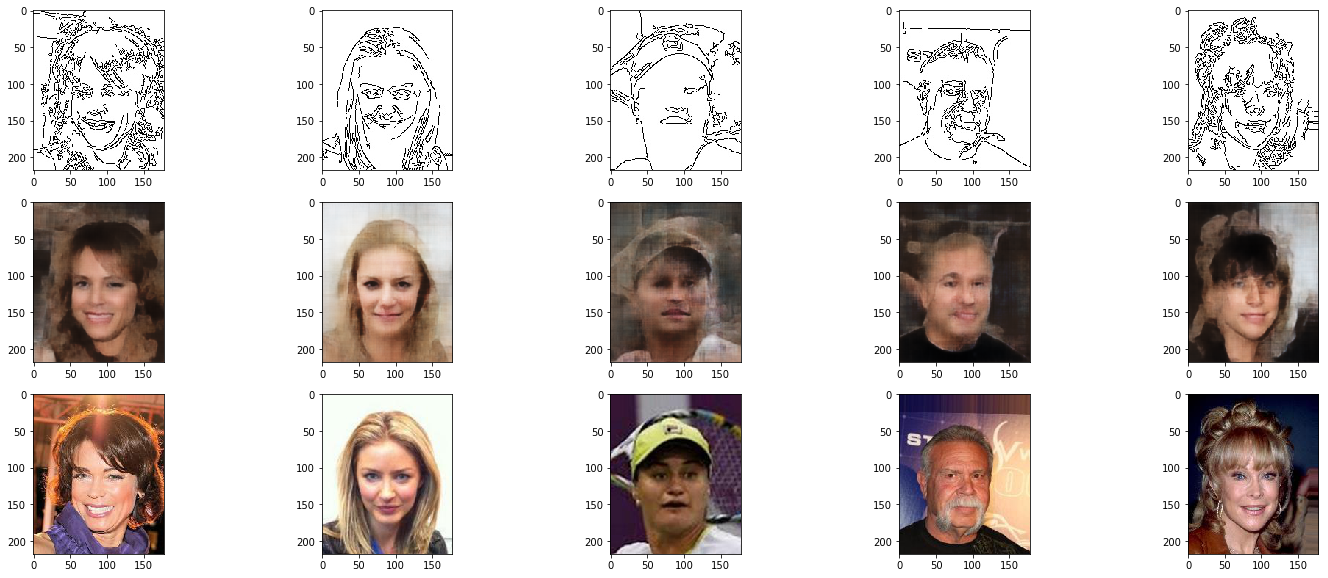

In [11]:
edges, origs = next(image_generator(test_img_files[-30:], test_edge_files[-30:], 5))
generated = model.predict_on_batch(edges)

plt.figure(figsize=(5*5, 10))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(edges[i], 'gray')
    plt.subplot(3, 5, i+1+5)
    plt.imshow(generated[i])
    plt.subplot(3, 5, i+1+2*5)
    plt.imshow(origs[i])

In [12]:
model.save('edge2face_model_mae.v2.h5')